# LTE Broadcast Parameter Extraction (Auto Bandwidth)

Bu sunum defteri, kısa LTE IQ kayıtlarından (\.raw/\.iq/\.mat) otomatik bant genişliği ve örnekleme hızı ipuçlarıyla senkronizasyon ve PBCH/MIB çıkarımını gösterir.

In [1]:
# Ortam ayarı: src yolunu ekle
import sys
from pathlib import Path
candidates = [Path().resolve(), Path().resolve().parent]
for cand in candidates:
    if (cand / "src").exists():
        if str(cand) not in sys.path:
            sys.path.insert(0, str(cand))
        break


## Yetenek Özeti
- Giriş formatları: `.raw`/`.iq` (interleaved float32), `.mat` (v7/v7.3) \+ isteğe bağlı `--key`.
- Otomatik bant seçimi: 1.4/3/5/10/15/20 MHz (Normal CP) arasından PSS metriğiyle seçim; `.mat` içindeki `fs`/`Fs`/`samp_rate`/`sample_rate` ipuçları ile önceliklendirme.
- Senkronizasyon: PSS/SSS tespiti, PCI, CFO, zaman hizalaması.
- PBCH/MIB: Faz tabanlı EQ \+ opsiyonel CRS EQ, scrambler/derate-match/Viterbi, sınırlı veya kapatılabilir brute-force.
- TDD heuristikleri: özel alt-çerçeve ve UL/DL konfigürasyonu için enerji tabanlı tahminler.
- Çıktı özetleyici: `pretty_print_results` ile hızla okunabilir rapor.

## Hızlı Başlangıç
Aşağıdaki hücreyi, giriş yolunu ve gerekli bayrakları düzenleyerek çalıştırın. PBCH brute-force'u hız için kapatabilir veya aday sayısını sınırlayabilirsiniz.

In [2]:
# Giriş dosyasını belirtin (.raw/.iq/.mat)
from pathlib import Path
from src.lte_params import load_iq_auto_with_meta, analyze_lte_iq, pretty_print_results
# repo kökünü bul (src klasörü olan en yakın üst dizin)
repo_root = Path().resolve()
while repo_root != repo_root.parent and not (repo_root / "src").exists():
    repo_root = repo_root.parent
input_path = repo_root / "LTEIQ.raw"  # örnek: repo_root / "input.mat"
# MATLAB için değişken adı gerekiyorsa belirtin, yoksa None bırakın
mat_key = None  # ör: "IQ"

# PBCH brute-force aramasını kapatmak veya sınırlandırmak için parametreler
enable_bruteforce = True
bruteforce_limit = 60  # 0 veya None sınırsız; küçük sayı hızlandırır

x, meta = load_iq_auto_with_meta(str(input_path), mat_key=mat_key)
res = analyze_lte_iq(
    x,
    config=None,  # otomatik bant genişliği seçimi
    enable_bruteforce=enable_bruteforce,
    bruteforce_limit=bruteforce_limit,
    fs_hint=meta.get("fs_hint"),
)
print(pretty_print_results(res))


AutoSelectedBandwidth_NDLRB: 50
AutoSelectedBandwidth_FS_Hz: 15360000.0
AutoSelectedBandwidth_NFFT: 1024
NDLRB: 50
NDLRB_from_MIB: 25
DuplexMode: FDD
CyclicPrefix: Normal
NCellID: 455
NCellID_from_MIB: 14
NID1: 151
NID2: 2
NSubframe: 0
FrameOffsetSamples: 11665
Estimated_CFO_rad_per_sample: -0.000023
PSS_metric: 0.967
SSS_metric: 0.994
PBCH_EQ_Method: phase_only
MIB_BitErrors: 0
MIB_RateMatchRV: 3
MIB_LLRStart: 31
CellRefP: 2
CellRefP_from_MIB: 2
PHICHDuration: Normal
PHICHDuration_from_MIB: Normal
Ng: 1
Ng_from_MIB: 1
NFrame: 671
NFrame_from_MIB: 671


## Akış Şeması
1. **Yükleme**: `load_iq_auto_with_meta` giriş formatını algılar, IQ + fs ipucu döner.
2. **Otomatik bant seçimi**: `analyze_lte_iq` PSS metriğine göre LTE bantlarını dener (fs ipucunu kullanarak).
3. **PSS/SSS**: PCI, CFO, zaman hizalaması ve duplex modu tahmini.
4. **PBCH**: Faz tabanlı EQ + opsiyonel CRS EQ; scrambler/derate-match/Viterbi; brute-force isteğe bağlı.
5. **TDD Heuristikleri**: Özel alt-çerçeve ve UL/DL konfigürasyon tahmini (kayıt yeterince uzun ise).
6. **Çıktı**: `pretty_print_results` metrikleri ve MIB alanlarını yazdırır.

## İpuçları
- Kısa kayıtlar için brute-force limitini küçük tutun veya kapatın (`enable_bruteforce=False`).
- `.mat` dosyalarında `fs`/`Fs` scalar'ı eklemek otomatik bant seçiminde fayda sağlar.
- TDD enerji tahminleri için en az birkaç subframe gereklidir; 5 ms kayıtlar kısıtlı bilgi verir.
- PBCH MIB hata sayıları (`MIB_BitErrors`) sıfır değilse sonuçları ihtiyatla yorumlayın.

# Örnek Çıktılar

In [3]:
# Stream output: pretty-print a fake result
from src.lte_params import pretty_print_results
mock = {
    'NDLRB': 50,
    'DuplexMode': 'FDD',
    'NCellID': 123,
    'PSS_metric': 0.98,
    'SSS_metric': 0.99,
    'Estimated_CFO_rad_per_sample': -1.2e-5,
}
print(pretty_print_results(mock))


AutoSelectedBandwidth_NDLRB: Unknown
AutoSelectedBandwidth_FS_Hz: Unknown
AutoSelectedBandwidth_NFFT: Unknown
NDLRB: 50
NDLRB_from_MIB: Unknown
DuplexMode: FDD
CyclicPrefix: Unknown
NCellID: 123
NCellID_from_MIB: Unknown
NID1: Unknown
NID2: Unknown
NSubframe: Unknown
FrameOffsetSamples: Unknown
Estimated_CFO_rad_per_sample: -0.000012
PSS_metric: 0.980
SSS_metric: 0.990
PBCH_EQ_Method: Unknown
MIB_BitErrors: Unknown
MIB_RateMatchRV: Unknown
MIB_LLRStart: Unknown
CellRefP: Unknown
CellRefP_from_MIB: Unknown
PHICHDuration: Unknown
PHICHDuration_from_MIB: Unknown
Ng: Unknown
Ng_from_MIB: Unknown
NFrame: Unknown
NFrame_from_MIB: Unknown


In [4]:
# Execute result: quick dictionary view
{
    'AutoSelectedBandwidth_NDLRB': 50,
    'AutoSelectedBandwidth_FS_Hz': 15.36e6,
    'AutoSelectedBandwidth_NFFT': 1024,
}


{'AutoSelectedBandwidth_NDLRB': 50,
 'AutoSelectedBandwidth_FS_Hz': 15360000.0,
 'AutoSelectedBandwidth_NFFT': 1024}

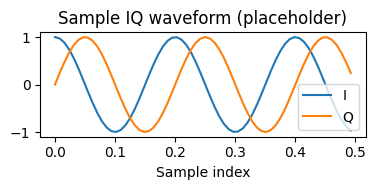

In [5]:
# Display data: simple matplotlib plot placeholder (image/png)
import numpy as np
import matplotlib.pyplot as plt
n = np.arange(0, 1, 1/128)
pss_like = np.exp(1j * 2 * np.pi * 5 * n)
plt.figure(figsize=(4,2))
plt.plot(n[:64], pss_like.real[:64], label='I')
plt.plot(n[:64], pss_like.imag[:64], label='Q')
plt.title('Sample IQ waveform (placeholder)')
plt.xlabel('Sample index')
plt.legend()
plt.tight_layout()
plt.show()


## Görsel Çıktılar

### 1) Merkez bant enerji ısı haritası
Sinyalin ilk subframe'lerinde merkez 62 taşıyıcı ortalamasının ısı haritası.

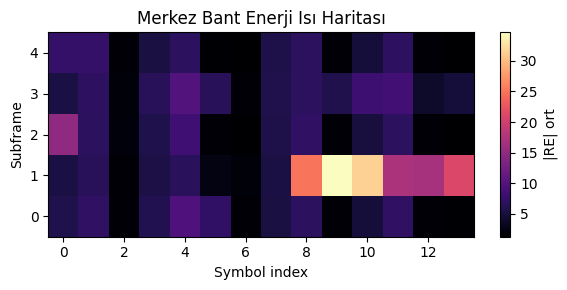

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from src.lte_params import LTEConfig, compute_center_energy_matrix

# Sonuçlardan yapılandırma oluştur
nfft = int(res.get('AutoSelectedBandwidth_NFFT') or res.get('NDLRB', 50)/50*1024)
fs = float(res.get('AutoSelectedBandwidth_FS_Hz') or 15.36e6)
ndlrb = int(res.get('NDLRB') or 50)
cfg = LTEConfig(nfft=nfft, fs=fs, ndlrb=ndlrb)
heat = compute_center_energy_matrix(x, cfg, subframes=5)
plt.figure(figsize=(6,3))
plt.imshow(heat, aspect='auto', origin='lower', cmap='magma')
plt.xlabel('Symbol index')
plt.ylabel('Subframe')
plt.title('Merkez Bant Enerji Isı Haritası')
plt.colorbar(label='|RE| ort')
plt.tight_layout()
plt.show()


Merkez bant ısı haritası, subframe/simge bazında downlink etkinliğini görselleştirir; TDD özel alt-çerçeve/UL boşlukları enerji düşüşü olarak görülür.

### 2) PBCH takımyıldızı ve LLR histogramı
PBCH sembollerinin faz-düzeltmeli takımyıldızı ve elde edilen LLR dağılımı.

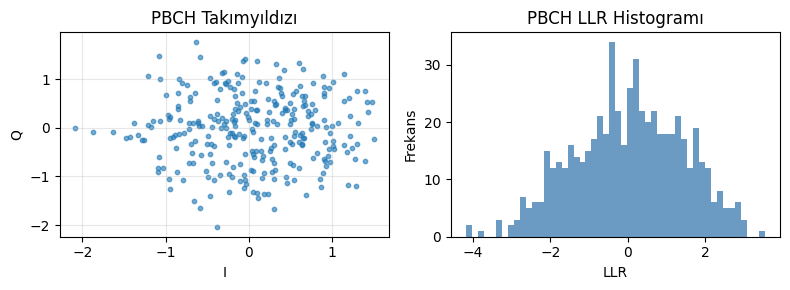

In [7]:
import matplotlib.pyplot as plt
from src.lte_params import estimate_cfo_for_subframe
from src.pbch import extract_pbch_re, estimate_common_phase, apply_phase, normalize_amplitude, qpsk_llrs

cfo_sf = estimate_cfo_for_subframe(x, cfg, 0)
pbch_re = extract_pbch_re(x, cfg, 0, cfo_sf)
theta = estimate_common_phase(pbch_re)
pbch_eq = normalize_amplitude(apply_phase(pbch_re, theta))
pts = pbch_eq.reshape(-1)
llrs = qpsk_llrs(pbch_eq)
fig, ax = plt.subplots(1,2, figsize=(8,3))
ax[0].scatter(pts.real, pts.imag, s=10, alpha=0.6)
ax[0].set_title('PBCH Takımyıldızı')
ax[0].set_xlabel('I')
ax[0].set_ylabel('Q')
ax[0].grid(True, alpha=0.3)
ax[1].hist(llrs, bins=50, color='steelblue', alpha=0.8)
ax[1].set_title('PBCH LLR Histogramı')
ax[1].set_xlabel('LLR')
ax[1].set_ylabel('Frekans')
plt.tight_layout()
plt.show()


LLR histogramı, yumuşak bit güvenini gösterir; dağılımın sıfıra yakın yığılması belirsizlik, uçlara gitmesi yüksek güven demektir.

### 3) PSS/SSS korelasyon metrikleri
Slotlar boyunca PSS korelasyon gücünün hızlı bir görünümü.

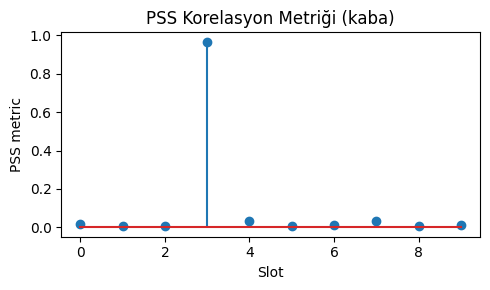

In [8]:
from src.lte_params import detect_pss_across_slots
import numpy as np
import matplotlib.pyplot as plt

# PSS eşleşmesini slot bazında kaba enerjiyle göster
slot_samples = cfg.slot_samples
num_slots = min(10, len(x)//slot_samples)
metrics = []
for s in range(num_slots):
    seg = x[s*slot_samples:(s+1)*slot_samples]
    res_slot = detect_pss_across_slots(seg, cfg)
    metrics.append(res_slot.get('metric', 0))
plt.figure(figsize=(5,3))
plt.stem(range(num_slots), metrics)
plt.xlabel('Slot')
plt.ylabel('PSS metric')
plt.title('PSS Korelasyon Metriği (kaba)')
plt.tight_layout()
plt.show()


## Geniş Görseller ve Diagnostikler

Bu bölüm, sinyalin zaman/frekans görünümünü ve PBCH/MIB tanılama grafiklerini topluca sunar.

In [9]:
# Ortak bağlam: konfigürasyon, PBCH çıkarımı
import numpy as np
import matplotlib.pyplot as plt
from src.lte_params import LTEConfig, estimate_cfo_for_subframe, compute_center_energy_matrix, detect_pss_across_slots
from src.pbch import extract_pbch_re, estimate_common_phase, apply_phase, normalize_amplitude, pbch_equalize_with_crs, qpsk_llrs

fs = float(res.get('AutoSelectedBandwidth_FS_Hz') or 15.36e6)
ndlrb = int(res.get('NDLRB') or res.get('AutoSelectedBandwidth_NDLRB') or 50)
nfft = int(res.get('AutoSelectedBandwidth_NFFT') or max(128, 12*ndlrb//6*128//12))
cfg = LTEConfig(nfft=nfft, fs=fs, ndlrb=ndlrb)

# PBCH eşitleme (basit faz) ve CRS tabanlı kanal tahmini denemesi
theta = None
pbch_eq = None
llrs = None
channel_line = None
try:
    cfo_sf = estimate_cfo_for_subframe(x, cfg, 0)
    pbch_re = extract_pbch_re(x, cfg, 0, cfo_sf)
    theta = estimate_common_phase(pbch_re)
    pbch_eq = normalize_amplitude(apply_phase(pbch_re, theta))
    llrs = qpsk_llrs(pbch_eq)
    try:
        pbch_crs_eq, channel_line, _ = pbch_equalize_with_crs(pbch_re, int(res.get('NCellID', 0) or 0), ndlrb, cellrefp=int(res.get('CellRefP', 2) or 2))
    except Exception:
        channel_line = None
except Exception as exc:
    print(f"PBCH prep error: {exc}")


### Zaman domeni dalga formu (I/Q)

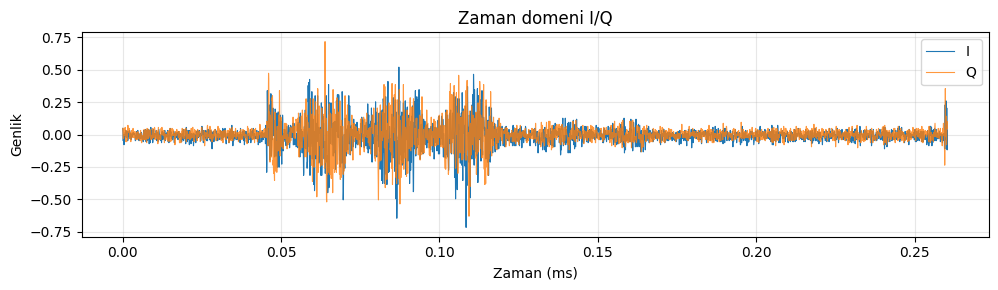

In [10]:
N = min(4000, len(x))
t = np.arange(N) / fs * 1e3  # ms
plt.figure(figsize=(10,3))
plt.plot(t, x[:N].real, label='I', lw=0.8)
plt.plot(t, x[:N].imag, label='Q', lw=0.8, alpha=0.8)
plt.xlabel('Zaman (ms)')
plt.ylabel('Genlik')
plt.title('Zaman domeni I/Q')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### Tekil-yan bant spektrum

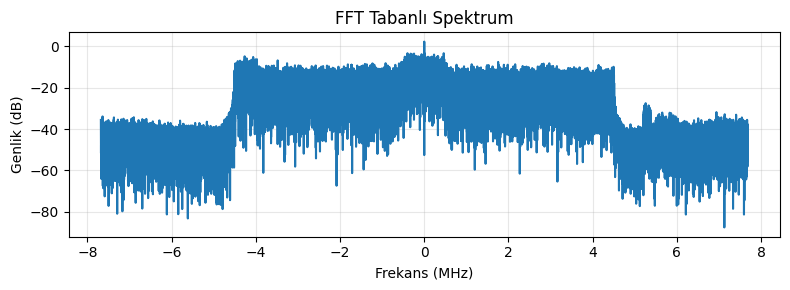

In [11]:
Nfft_plot = 65536 if len(x) > 65536 else 8192
seg = x[:Nfft_plot]
win = np.hanning(len(seg))
X = np.fft.fftshift(np.fft.fft(seg * win))
freq = (np.fft.fftfreq(len(seg), d=1/fs))
freq = np.fft.fftshift(freq)/1e6
psd = 20*np.log10(np.abs(X)/np.sqrt(len(seg))+1e-12)
plt.figure(figsize=(8,3))
plt.plot(freq, psd)
plt.xlabel('Frekans (MHz)')
plt.ylabel('Genlik (dB)')
plt.title('FFT Tabanlı Spektrum')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Spektrum, taşıyıcı merkezini ve bant genişliğini gözlemler; yan bantlardaki sızıntı veya ek tonlar parazit/LO kaçağına işaret edebilir.

### Zaman-frekans spektrogram

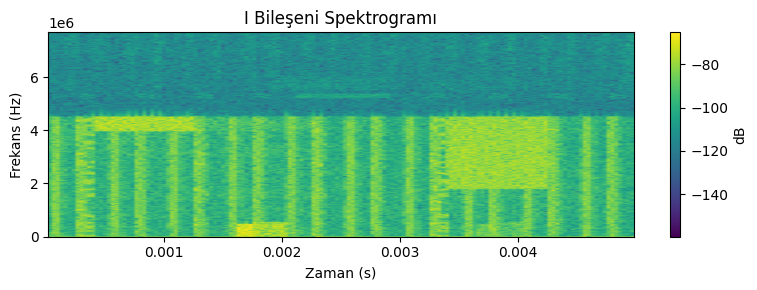

In [12]:
plt.figure(figsize=(8,3))
plt.specgram(x.real, NFFT=1024, Fs=fs, noverlap=512, cmap='viridis')
plt.xlabel('Zaman (s)')
plt.ylabel('Frekans (Hz)')
plt.title('I Bileşeni Spektrogramı')
plt.colorbar(label='dB')
plt.tight_layout()
plt.show()


Zaman-frekans spektrogramı, zaman içinde enerji değişimini gösterir; kısa kayıtta bile patlama/pilots ve boşluklar ayırt edilebilir.

### Merkez bant enerji ısı haritası ve kaynak ızgarası

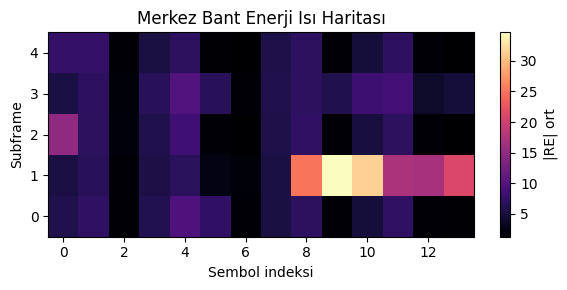

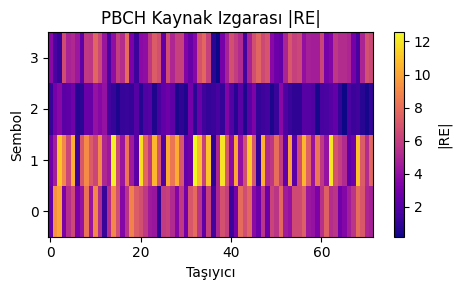

In [13]:
heat = compute_center_energy_matrix(x, cfg, subframes=5)
plt.figure(figsize=(6,3))
plt.imshow(heat, aspect='auto', origin='lower', cmap='magma')
plt.xlabel('Sembol indeksi')
plt.ylabel('Subframe')
plt.title('Merkez Bant Enerji Isı Haritası')
plt.colorbar(label='|RE| ort')
plt.tight_layout()
plt.show()

if 'pbch_re' in globals():
    plt.figure(figsize=(5,3))
    plt.imshow(np.abs(pbch_re), aspect='auto', origin='lower', cmap='plasma')
    plt.xlabel('Taşıyıcı')
    plt.ylabel('Sembol')
    plt.title('PBCH Kaynak Izgarası |RE|')
    plt.colorbar(label='|RE|')
    plt.tight_layout()
    plt.show()


Merkez bant ısı haritası, subframe/simge bazında downlink etkinliğini görselleştirir; TDD özel alt-çerçeve/UL boşlukları enerji düşüşü olarak görülür.

### PBCH kanal tahmini (CRS tabanlı)

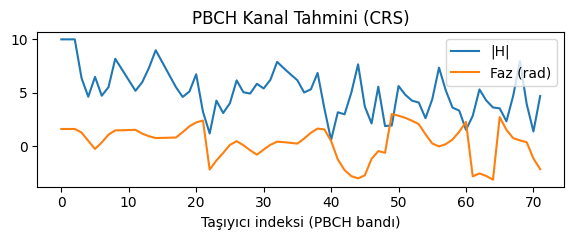

In [14]:
if channel_line is not None:
    plt.figure(figsize=(6,2.5))
    plt.plot(np.abs(channel_line), label='|H|')
    plt.plot(np.angle(channel_line), label='Faz (rad)')
    plt.xlabel('Taşıyıcı indeksi (PBCH bandı)')
    plt.title('PBCH Kanal Tahmini (CRS)')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print('CRS tabanlı kanal tahmini yok (varsayılan faz eşitleme kullanıldı).')


CRS tabanlı kanal tahmini, PBCH bandındaki genlik/faz düzeltmesini gösterir; derin oyuklar frekans-seçici sönümlemeyi işaret eder.

### PBCH takımyıldızı ve MATLAB-benzeri karar özeti

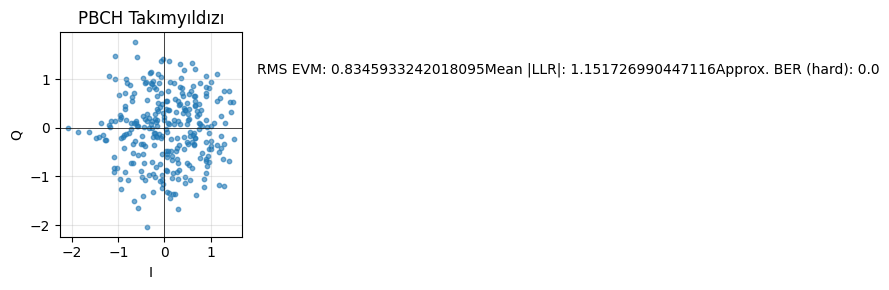

In [16]:
if pbch_eq is not None:
    pts = pbch_eq.reshape(-1)
    decis = np.sign(pts.real) + 1j*np.sign(pts.imag)
    evm_rms = np.sqrt(np.mean(np.abs(pts - decis)**2))
    fig, ax = plt.subplots(1,2, figsize=(8,3))
    ax[0].scatter(pts.real, pts.imag, s=10, alpha=0.6)
    ax[0].axhline(0, color='k', lw=0.5); ax[0].axvline(0, color='k', lw=0.5)
    ax[0].set_title('PBCH Takımyıldızı')
    ax[0].set_xlabel('I'); ax[0].set_ylabel('Q'); ax[0].grid(True, alpha=0.3)
    # MATLAB-benzeri karar özeti
    ber_est = np.mean(np.sign(pts.real)!=np.sign(decis.real))*0.5 + np.mean(np.sign(pts.imag)!=np.sign(decis.imag))*0.5
    summary = {
        'RMS EVM': float(evm_rms),
        'Mean |LLR|': float(np.mean(np.abs(llrs))) if llrs is not None else None,
        'Approx. BER (hard)': float(ber_est),
    }
    ax[1].axis('off')
    txt = "".join([f"{k}: {v}" for k,v in summary.items()])
    ax[1].text(0.0,0.8, txt, fontsize=10)
    plt.tight_layout(); plt.show()
else:
    print('PBCH sembolleri mevcut değil.')


PBCH takımyıldızı ve EVM, demodülasyon kalitesini gösterir; noktalar çaprazda kümeleniyorsa faz/denge problemi, dağınıksa düşük SNR/çokyol etkisi olabilir.

### LLR histogramı ve kod bit hatası dağılımı (tahmini)

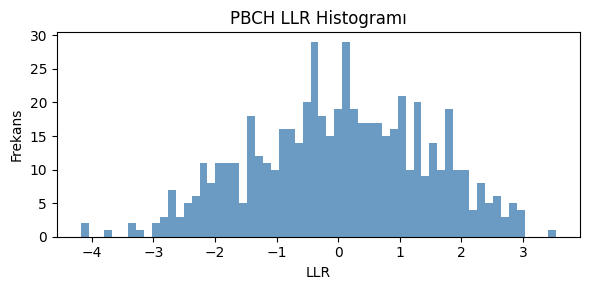

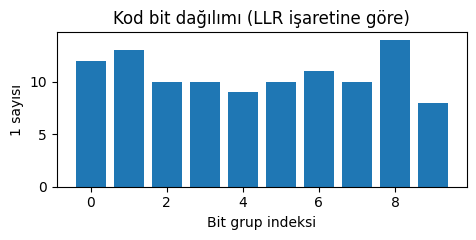

In [17]:
if llrs is not None:
    plt.figure(figsize=(6,3))
    plt.hist(llrs, bins=60, color='steelblue', alpha=0.8)
    plt.xlabel('LLR'); plt.ylabel('Frekans'); plt.title('PBCH LLR Histogramı')
    plt.tight_layout(); plt.show()
    # Hata tahmini: LLR işaretine göre 0/1 kararları
    bits = (llrs < 0).astype(int)
    # Gruplu bit sayımı (görsel amaçlı)
    chunk = 24
    errs = [np.sum(chunk_bits) for chunk_bits in bits.reshape(-1, chunk)[:10]] if bits.size >= chunk else bits.tolist()
    plt.figure(figsize=(5,2.5))
    plt.bar(range(len(errs)), errs)
    plt.xlabel('Bit grup indeksi'); plt.ylabel('1 sayısı')
    plt.title('Kod bit dağılımı (LLR işaretine göre)')
    plt.tight_layout(); plt.show()
else:
    print('LLR verisi yok.')


LLR histogramı, yumuşak bit güvenini gösterir; dağılımın sıfıra yakın yığılması belirsizlik, uçlara gitmesi yüksek güven demektir.

### Zarf üzerinden kısa-zaman FFT ile Doppler / sönümleme deseni

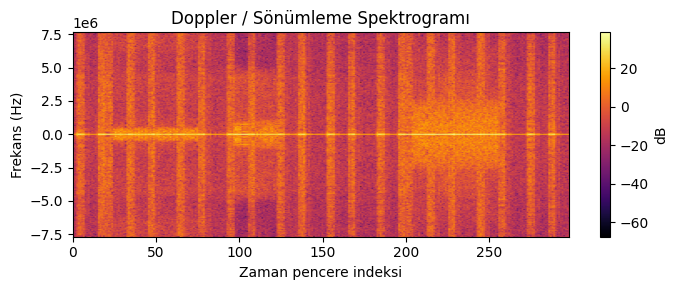

In [18]:
mag = np.abs(x)
win = 512
hop = 256
n_frames = max(1, (len(mag)-win)//hop)
stft = np.zeros((win, n_frames), dtype=complex)
for i in range(n_frames):
    seg = mag[i*hop:i*hop+win] * np.hanning(win)
    stft[:, i] = np.fft.fft(seg)
doppler = np.fft.fftshift(stft, axes=0)
freq_ax = np.fft.fftshift(np.fft.fftfreq(win, d=1/fs))
plt.figure(figsize=(7,3))
plt.imshow(20*np.log10(np.abs(doppler)+1e-9), aspect='auto', origin='lower', cmap='inferno', extent=[0, n_frames, freq_ax[0], freq_ax[-1]])
plt.xlabel('Zaman pencere indeksi'); plt.ylabel('Frekans (Hz)')
plt.title('Doppler / Sönümleme Spektrogramı')
plt.colorbar(label='dB')
plt.tight_layout(); plt.show()


Zarfın kısa-zaman FFT’si, düşük hızlarda sessiz kalır; frekansta yayılan çizgiler hareket/Doppler veya zamansal sönümleme paternlerini işaret eder.

### PBCH güç spektrumu ve EVM

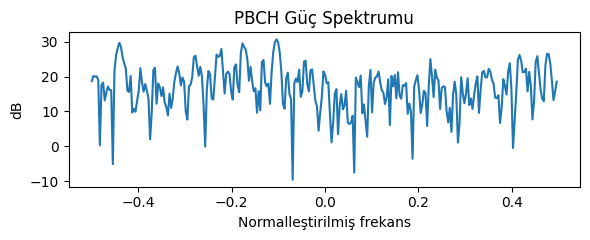

In [19]:
if pbch_eq is not None:
    flat = pbch_eq.reshape(-1)
    spec = np.fft.fftshift(np.fft.fft(flat * np.hanning(len(flat))))
    freq = np.fft.fftshift(np.fft.fftfreq(len(flat), d=1))
    plt.figure(figsize=(6,2.5))
    plt.plot(freq, 20*np.log10(np.abs(spec)+1e-9))
    plt.xlabel('Normalleştirilmiş frekans'); plt.ylabel('dB')
    plt.title('PBCH Güç Spektrumu')
    plt.tight_layout(); plt.show()
else:
    print('PBCH sembolleri mevcut değil.')


PBCH güç spektrumu, 6 RB genişliğindeki yayın kanalının frekans cevabını gösterir; simetrik ve düz olması ideal, dalgalanmalar kanal etkisidir.

### PSS/SSS korelasyon görselleştirmesi

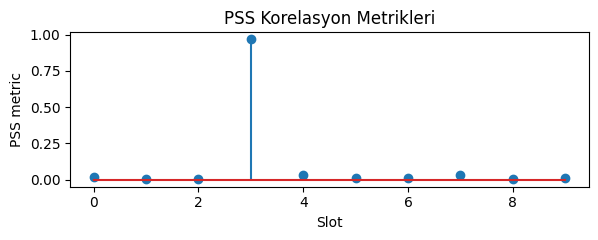

In [20]:
try:
    pss_res = detect_pss_across_slots(x, cfg)
    slot_samples = cfg.slot_samples
    num_slots = min(12, len(x)//slot_samples)
    metrics = []
    for s in range(num_slots):
        seg = x[s*slot_samples:(s+1)*slot_samples]
        res_slot = detect_pss_across_slots(seg, cfg)
        metrics.append(res_slot.get('metric', 0))
    plt.figure(figsize=(6,2.5))
    plt.stem(range(num_slots), metrics)
    plt.xlabel('Slot'); plt.ylabel('PSS metric'); plt.title('PSS Korelasyon Metrikleri')
    plt.tight_layout(); plt.show()
except Exception as exc:
    print(f'PSS plot error: {exc}')


PSS korelasyon metriği, slotlar boyunca senkronizasyon güvenini gösterir; belirgin bir tepe, PSS konumunun sağlam olduğunu gösterir.

### Çerçeve yapısı görünümü

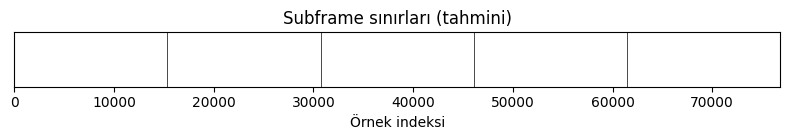

In [21]:
sf = cfg.subframe_samples
num_sf = min(5, len(x)//sf)
plt.figure(figsize=(8,1.5))
for i in range(num_sf+1):
    plt.axvline(i*sf, color='k', lw=0.5)
plt.xlim(0, num_sf*sf)
plt.ylim(0,1)
plt.yticks([])
plt.xlabel('Örnek indeksi')
plt.title('Subframe sınırları (tahmini)')
plt.tight_layout(); plt.show()


Subframe sınırı görünümü, hizalamanın tahmini örnek indekslerini gösterir; veri kaydırmaları veya yanlış bant seçimi burada fark edilebilir.

### Teorik BER vs SNR (QPSK) ve BLER tahmini

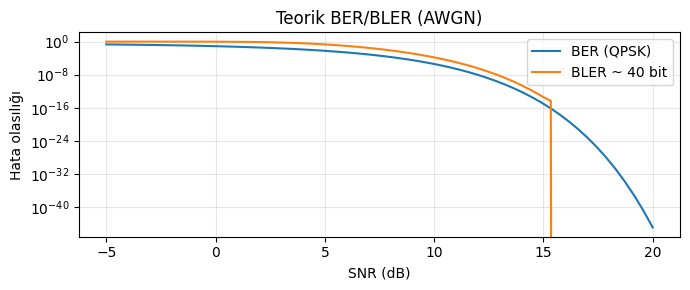

In [22]:
from math import sqrt
from scipy.special import erfc
snr_db = np.linspace(-5, 20, 60)
ber = 0.5*erfc(np.sqrt(10**(snr_db/10)))
bits = 40  # MIB uzunluğu (payload+CRC)
bler = 1 - (1-ber)**bits
plt.figure(figsize=(7,3))
plt.semilogy(snr_db, ber, label='BER (QPSK)')
plt.semilogy(snr_db, bler, label='BLER ~ 40 bit')
plt.xlabel('SNR (dB)'); plt.ylabel('Hata olasılığı')
plt.title('Teorik BER/BLER (AWGN)')
plt.grid(True, which='both', alpha=0.3)
plt.legend()
plt.tight_layout(); plt.show()


Teorik BER/BLER eğrileri, PBCH için beklenen hata oranını (AWGN) verir; ölçülen EVM/LLR güveni ile karşılaştırarak kanal kalitesi sezilebilir.